In [1]:
import os
import time
import sys
import scipy
import glob
import importlib
import _pickle as pkl
import pandas as pd
import numpy as np
import matplotlib as mpl
mpl.use('nbagg')
import seaborn as sns
import pylab as pl
import _pickle as pkl

from datetime import datetime

# import some custom funcs
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import utils as util
import behavior as butil

import shutil
import scipy.stats as spstats

import trajectory as traj
import plotting as putil

In [2]:
util.set_sns_style(style='dark', min_fontsize=12)
pl.rcParams['svg.fonttype'] = 'none'
%matplotlib notebook

plot_style = 'white'
util.set_sns_style(style=plot_style)
bg_color = 'k' if plot_style=='white' else 'w' 
boutdir_palette = {'inodor': bg_color, 'inbound': 'c', 'outbound': 'm'}
plot_st = '_yt' if plot_style == 'white' else ''
instrip_palette = {True: 'r', False: 'cornflowerblue'}

# load data

In [3]:
#srcdir = '/home/julianarhee/Documents/projects/plume-tracking/data'
# rootdir='/Users/julianarhee/Library/CloudStorage/GoogleDrive-edge.tracking.ru@gmail.com/My Drive/Edge_Tracking/Data'
rootdir = util.get_rootdir()
print(rootdir)

srcdir = os.path.join(rootdir, 'jyr', 'plume_geometries', 'data')
fnames = os.listdir(srcdir)
fnames

/home/julianarhee/edgetracking-googledrive/Edge_Tracking/Data


['errors',
 'from_andy',
 'T_plume.pkl',
 'combined_df.pkl',
 '45-degree.pkl',
 '15-degree.pkl',
 '0-curated.pkl',
 'ets',
 'info.pkl',
 'T-plume.pkl']

In [109]:
experiment = 'T-plume' #'45-degree' # '15-degree' #'T-plume' #'0-curated' #'45-degree' #'0-curated' #'15-degree' #'T_plume'
create_new = True


et_fpath = os.path.join(etdir, 'et_{}.pkl'.format(experiment)) # processed data
combined_fpath = os.path.join(srcdir, '{}.pkl'.format(experiment)) # original data

if os.path.exists(et_fpath) and create_new is False:
    try:
        print("loading: ", et_fpath)
        with open(et_fpath, 'rb') as f:
            ddict = pkl.load(f)
        etdf_filt = ddict['etdf_filt']
        entries_exits = ddict['entries_exits']
    except Exception as e:
        print(e)
        create_new = True
        print("new")

if create_new:
    with open(combined_fpath, 'rb') as f:
        df0_all = pkl.load(f)
    print(df0_all.shape)

(577073, 34)


# output path

In [110]:
figid = combined_fpath
#figdir = srcdir.replace('data', 'figures') #os.path.join(figdir, experiment)
figdir = os.path.join(srcdir.replace('data', 'figures'), experiment)
if not os.path.exists(figdir):
    os.makedirs(figdir)
print("Save figures to: ", figdir)
if not os.path.exists(figdir):
    os.makedirs(figdir)

Save figures to:  /home/julianarhee/edgetracking-googledrive/Edge_Tracking/Data/jyr/plume_geometries/figures/T-plume


# zero traj

In [111]:
# zero trajectory
d_list = []
for fn, df_ in df0_all.groupby('filename'):
    df_z = putil.zero_trajectory(df_)
    d_list.append(df_z)
df_zero = pd.concat(d_list, axis=0).reset_index(drop=True)

In [112]:
file_lut = dict((fi, fn) for fi, fn in enumerate(df_zero['filename'].unique()))
print(len(file_lut))

13


# get ET

In [113]:
strip_width=50
strip_sep=1000
if experiment=='45-degree':
    # TODO: make this less janky -- crossovers bec downwind 
    max_crossovers = 4
    max_instrip_upwind_percent=0.5
    min_outside_bouts=5
    max_crossover_to_dist_ratio=4/500
    min_global_upwind_dist=400
elif experiment=='0-curated':
    max_crossovers = 0
    max_instrip_upwind_percent=0.5
    min_outside_bouts=5
    max_crossover_to_dist_ratio=1/500
    min_global_upwind_dist=400
else:
    max_crossovers = 4
    max_instrip_upwind_percent=0.5
    min_outside_bouts=5
    max_crossover_to_dist_ratio=4/500
    min_global_upwind_dist=400

if experiment=='T-plume':
    et_ixs = [3, 4, 9, 11]
    ets = [file_lut[i] for i in et_ixs]
    aggr_figname = 'traj_manually-selected'
else:
    ets=[]
    for fn, df_ in df_zero.groupby('filename'):
        odor_bounds = butil.find_strip_borders(df_, strip_angle=45,
                                                entry_ix=df_[df_['instrip']].iloc[0].name,
                                                strip_width=strip_width, strip_sep=strip_sep)
        et_bouts, et_boutstats, et_passkey = traj.find_et_bouts(df_,
                                            odor_bounds, strip_width=strip_width, strip_sep=strip_sep, 
                                            max_instrip_upwind_percent=max_instrip_upwind_percent, 
                                            max_crossovers=max_crossovers, 
                                            max_crossover_to_dist_ratio=max_crossover_to_dist_ratio,
                                            min_outside_bouts=min_outside_bouts,
                                            min_global_upwind_dist=min_global_upwind_dist)
        if len(et_bouts)>0:
            ets.append(fn) #'{}.log'.format(fn))
    aggr_figname = 'traj_max-crossovers-{}_min-outside-bouts-{}_crossoverdist_ratio-{}_min-global-upwind-{}_n{}'\
                .format(max_crossovers, min_outside_bouts, '1per500mm', min_global_upwind_dist, len(ets))
print(aggr_figname)

traj_manually-selected


In [114]:
print(len(file_lut))

13


In [115]:
print(len(ets))
etdf_zero = df_zero[df_zero['filename'].isin(ets)].copy()
print("{} of {} trajectories are ET.".format(etdf_zero['filename'].nunique(), df_zero['filename'].nunique()))

4
4 of 13 trajectories are ET.


# plot ETs

<IPython.core.display.Javascript object>


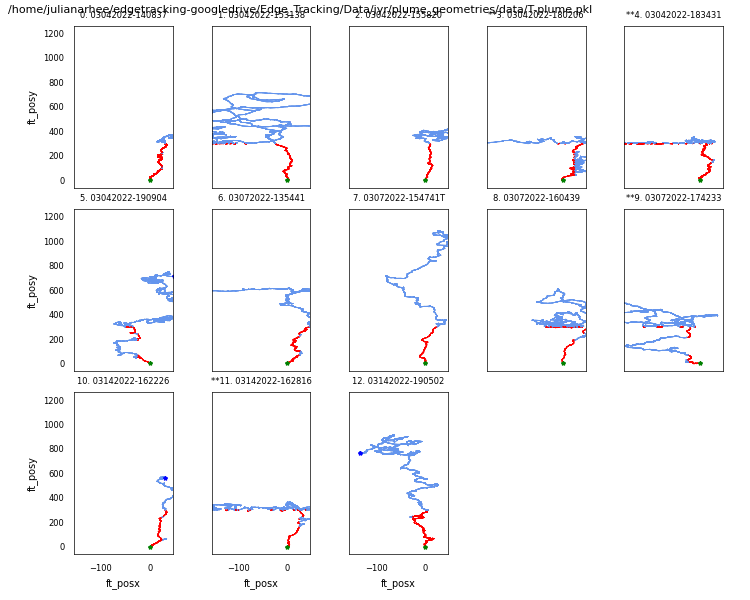

In [116]:
#putil.plot_array_of_trajectories(df, nr=3, nc=4, title='fly_id')
nr=3 #2
nc=5 #9 #7
fig, axn = pl.subplots(nr, nc, figsize=(nc*1.5,6), sharex=True, sharey=True)
for fi, fn in file_lut.items(): #fi, (fn, df_) in enumerate(df.groupby('filename')):
    df_ = df_zero[df_zero['filename']==fn].copy()
    ax=axn.flat[fi]
    butil.plot_trajectory(df_, ax =ax, palette=instrip_palette)
    ax.set_aspect(0.25)
    ax.legend_.remove()
    if fn in ets:
        title='**{}. {}'.format(fi, fn.split('_')[0])
    else:
        title='{}. {}'.format(fi, fn.split('_')[0])
    ax.set_title(title, fontsize=6)
for i in np.arange(fi+1, nr*nc):
    ax=axn.flat[i]
    ax.axis('off')
pl.tight_layout()
# label and save
util.label_figure(fig, figid)
pl.savefig(os.path.join(figdir, 'trajectories_{}.png'.format(experiment)))

## plot all ETs together, if want

In [117]:
plot_all=False
if plot_all:
    #putil.plot_array_of_trajectories(df, nr=3, nc=4, title='fly_id')
    nr=5 #2
    nc=7 #8 #6
    fig, axn = pl.subplots(nr, nc, figsize=(nc*1.5,nr*2), sharex=True, sharey=True)
    for fi, (fn, df_) in enumerate(etdf_zero.groupby('filename')):
        ax=axn.flat[fi]
        last_outbout = df_[df_['instrip']]['boutnum'].max()

        butil.plot_trajectory(df_[df_['boutnum']<=last_outbout], ax =ax, palette=instrip_palette, plot_start=False)
        ax.set_aspect(0.25)
        ax.legend_.remove()
        title='{}. {}'.format(fi, fn.split('_')[0])
        ax.set_title(title, fontsize=6)
        ax.axis('off')
        if fi==0:
            leg_xpos = -200; leg_ypos=0; leg_scale=100;
            putil.vertical_scalebar(ax, leg_xpos=leg_xpos, leg_ypos=leg_ypos, fontsize=7, color=bg_color)

    for i in np.arange(fi+1, nr*nc):
        ax=axn.flat[i]
        ax.axis('off')
    pl.tight_layout()
    fig.text(0.1, 0.9, 'edge-trackers', fontsize=7)
    util.label_figure(fig, figid)

    pl.savefig(os.path.join(figdir, 'trajectories-ETs_{}{}.png'.format(experiment, plot_st)))

# filter first and last bout

In [118]:
smooth_window=11
rdp_epsilon=1

xvar='ft_posx'
yvar='ft_posy'

if experiment=='T-plume':
    y_thresh = 300 - strip_width/2 
elif experiment in ['0-curated', '0-degree']:
    y_thresh = 0
else:
    y_thresh = etdf_zero['ft_posy'].min()
print(y_thresh)
etdf_filt = traj.filter_first_instrip_last_outstrip(etdf_zero, y_thresh=y_thresh)

275.0


#### plot by hue, to make sure going along edge

In [119]:
plot_by_hue=False
if plot_by_hue:
    curr_figdir = os.path.join(figdir, 'by-individual')
    if not os.path.exists(curr_figdir):
        os.makedirs(curr_figdir)
    print(curr_figdir)

    for fn, df_ in etdf_filt.groupby('filename'):
        print(fn)
        fig, axn = pl.subplots(1, 3, figsize=(9,4), sharex=True, sharey=True)
        butil.plot_trajectory(df_, ax=axn[0], palette=instrip_palette)
        butil.plot_trajectory(df_, hue_varname='boutdir', palette=boutdir_palette, ax=axn[1])
        butil.plot_trajectory(df_, hue_varname='rel_time', palette='viridis', ax=axn[2])
        pl.subplots_adjust(wspace=0.75)
        for ax in axn:
            ax.set_aspect(1)
            if experiment=='T-plume':
                ax.axhline(y=300, linestyle=':', lw=0.5, color=bg_color)
        pl.tight_layout()
        axn[0].set_title(fn, loc='left', fontsize=6)

        util.label_figure(fig, figid)
        pl.savefig(os.path.join(curr_figdir, 'trajectory-hue_{}.png'.format(fn)))


# add odor_heading (heading rel to odor)

In [120]:
if experiment=='T-plume':
    odor_angle = np.deg2rad(90)
else:
    deg = int(experiment.split('-')[0])
    print(deg)
    odor_angle = np.deg2rad(deg)
# add to df
etdf_filt['odor_heading'] = etdf_filt['ft_heading'] + odor_angle #np.pi/2
p = util.unwrap_and_constrain_angles(etdf_filt['odor_heading'].values)
etdf_filt['odor_heading'] = p #-p 

# RDP

In [121]:
etdf_filt = traj.rdp_trajectories(etdf_filt, rdp_epsilon=rdp_epsilon)
etdf_filt = etdf_filt.groupby(['filename', 'boutnum'], as_index=False).apply(butil.rdp_to_heading)
entries_exits = traj.get_entry_exit_angles_rdp(etdf_filt)

/tmp/ipykernel_1920985/3834434400.py:2: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  etdf_filt = etdf_filt.groupby(['filename', 'boutnum'], as_index=False).apply(butil.rdp_to_heading)
/home/julianarhee/Repositories/plume-tracking/trajectory.py:423: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  xd = pd.concat([df_, added_inodor], axis=0).drop_duplicates()
/home/julianarhee/Repositories/plume-tracking/trajectory.py:423: FutureWarning: In a future version, object-dtype columns with all-bool values will not be includ

# plot summaries for each fly

In [122]:
rdp_boutdir_palette = {'inside': 'gray', 'exit': 'r', 'entry': 'cornflowerblue'}

/home/julianarhee/edgetracking-googledrive/Edge_Tracking/Data/jyr/plume_geometries/figures/T-plume/by-individual


<IPython.core.display.Javascript object>


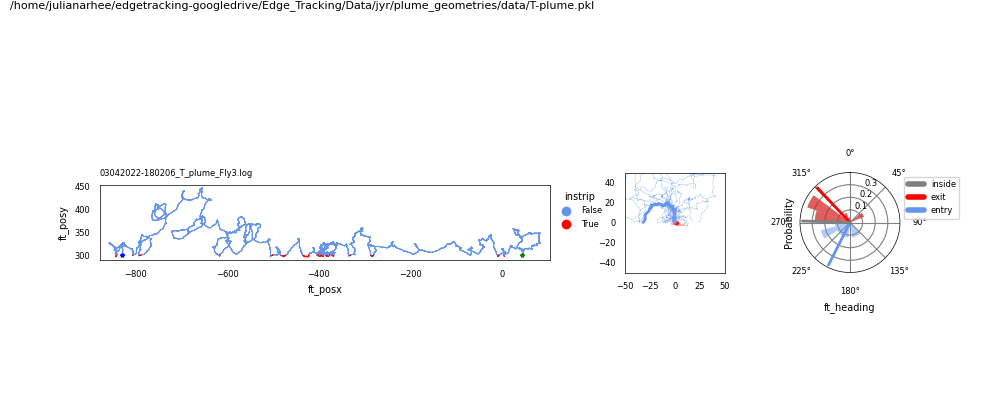

<IPython.core.display.Javascript object>


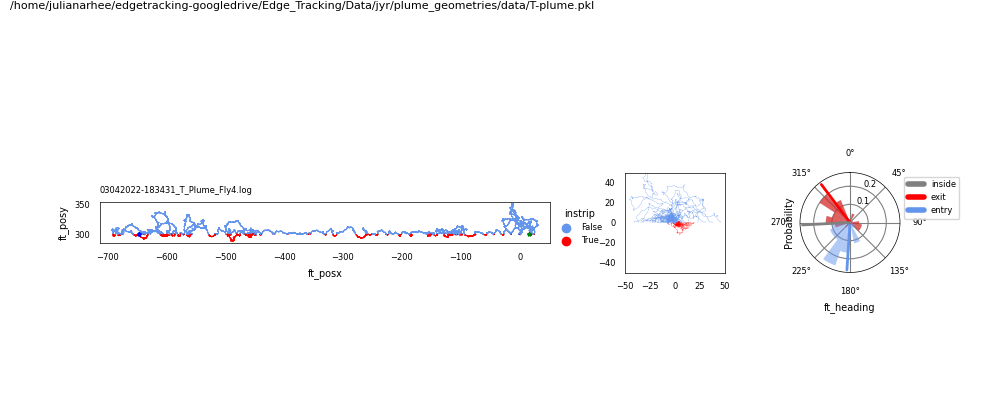

<IPython.core.display.Javascript object>


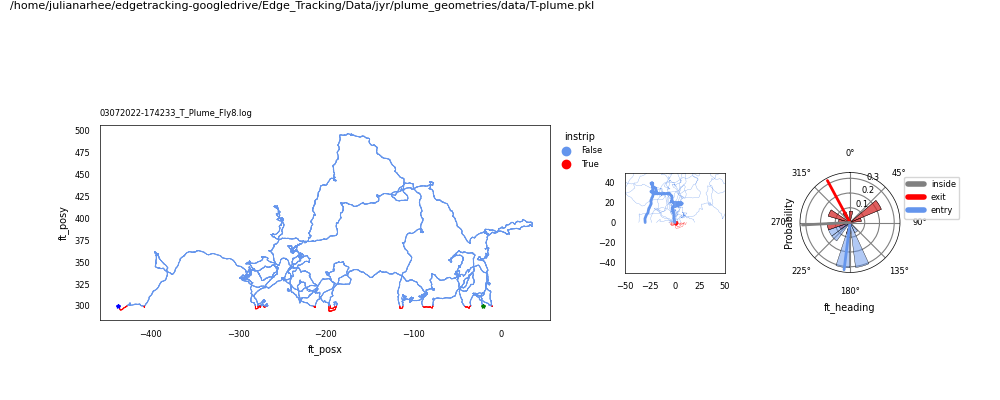

<IPython.core.display.Javascript object>


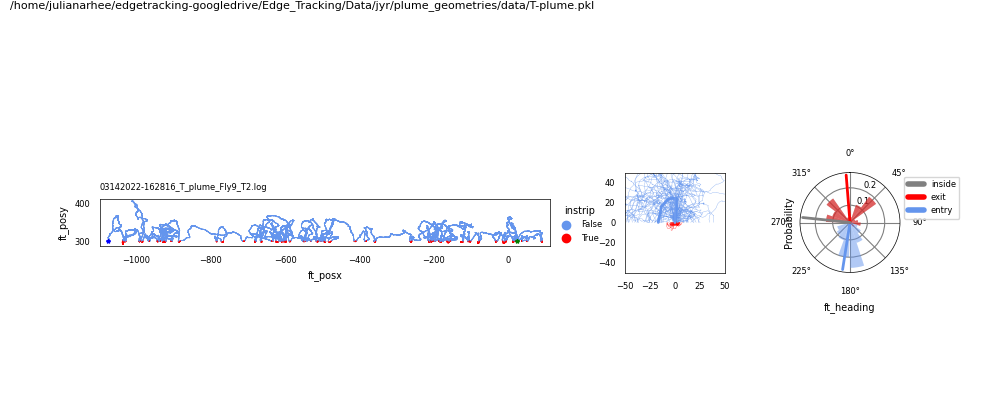

In [123]:
hist_var = 'ft_heading'
weights_var = 'euclid_dist'
bin_method='fd'
bout_lw = 0.2
avg_bout_lw=2
avg_lw=2
alpha=0.5
plot_polar = True

curr_figdir = os.path.join(figdir, 'by-individual')
if not os.path.exists(curr_figdir):
    os.makedirs(curr_figdir)
print(curr_figdir)

if experiment=='T-plume':
    y_thresh = 300 - strip_width/2 
elif experiment in ['0-curated', '0-degree']:
    y_thresh = 0
else:
    y_thresh = etdf_filt['ft_posy'].min()
for fn, d_ in etdf_filt.groupby('filename'):

    drop_cols = d_.columns[d_.isna().any()].tolist()
    incl_cols = [c for c in d_.columns if c not in drop_cols]
    d_ = d_[incl_cols].copy()

    fig = pl.figure(figsize=(10,4))
    npad = 2 if experiment=='T-plume' else 0
    gs = mpl.gridspec.GridSpec(1,3+npad)
    ax = fig.add_subplot(gs[0, 0:1+npad])
    # plot trajectory
    butil.plot_trajectory(d_, hue_varname='instrip', palette=instrip_palette, ax=ax)
    ax.set_title(fn, loc='left', fontsize=6)
    ax.set_aspect(1)

    # plot average bout
    ax = fig.add_subplot(gs[0, -2])
    # interpolate and align
    interp_x_in, interp_y_in, avg_x_in, avg_y_in = traj.align_and_average_bout_center0(d_[d_['instrip']], end_at_zero=True,
                                                                                interpolate=True, min_nbouts=1)
    interp_x_out, interp_y_out, avg_x_out, avg_y_out = traj.align_and_average_bout_center0(d_[~d_['instrip']], end_at_zero=False,
                                                                                interpolate=True, min_nbouts=1)                                                                                 
    # plot each bout
    ax.plot(interp_x_in, interp_y_in, lw=bout_lw, color=instrip_palette[True])
    ax.plot(interp_x_out, interp_y_out, lw=bout_lw, color=instrip_palette[False])
    # plot avg bout
    ax.plot(avg_x_in, avg_y_in, lw=avg_bout_lw, color=instrip_palette[True])
    ax.plot(avg_x_out, avg_y_out, lw=avg_bout_lw, color=instrip_palette[False])
    ax.axhline(y=0, linestyle=':', color='w', lw=0.25)
    ax.axvline(x=0, linestyle=':', color='w', lw=0.25)
    #ax.set_aspect(1)
    ax.set_ylim((-50, 50))
    ax.set_xlim((-50, 50))
    ax.set_aspect(1)
    
    # plot avg headings
    ax = fig.add_subplot(gs[0, -1], projection='polar') #pl.subplot(122, projection='polar')
    # histogram of ALL bouts across all flies
    ees = entries_exits[entries_exits['filename']==fn].copy() 
    sns.histplot(data=ees, x=hist_var, hue='rdp_boutdir', ax=ax, palette=rdp_boutdir_palette, 
                 edgecolor='k', lw=0.25, alpha=alpha, stat='probability', common_norm=False, bins=20)
    # plot current fly's average
    avg_ = ees.groupby('rdp_boutdir').apply(util.get_weighted_average, hist_var='rdp_arctan2', weights_var=weights_var)
    ylim = ax.get_ylim()[-1]
    b_list = []
    for rdp_bdir in ees['rdp_boutdir'].unique():
        avg_dir = avg_[rdp_bdir]
        if plot_polar:
            ax.plot([0, avg_dir], [0, ylim], alpha=1, color=rdp_boutdir_palette[rdp_bdir], lw=avg_lw, label=rdp_bdir) # theta is x
        else:
            ax.plot([avg_dir], [ylim], marker=fly_marker, alpha=alpha, color=rdp_boutdir_palette[rdp_bdir], label=rdp_bdir) # theta is x
    # axes
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    #ax.legend_.remove() 
    if plot_polar:
        ax.set_theta_zero_location("N")
        ax.set_theta_direction(-1)
    else:
        ax.set_box_aspect(1)
        ax.tick_params(which='both', axis='both', length=2, width=0.5, color='k',
                   direction='out', left=True, bottom=True)
        # ticks
        sns.despine(offset=4)
    # legend
    labels= ['inside', 'exit', 'entry']
    colors = [rdp_boutdir_palette[l] for l in labels]
    legh = putil.custom_legend(labels=labels, colors=colors)
    ax.legend(handles=legh, bbox_to_anchor=(1,1), loc='upper left')

    pl.tight_layout()
    pl.subplots_adjust(left=0.1, right=0.9, wspace=0.75, top=0.85)

    # save
    util.label_figure(fig, figid)
    pl.savefig(os.path.join(curr_figdir, '{}.png'.format(fn)))

# angles of exit vs entry

In [124]:
etdf_filt = etdf_filt.groupby(['filename', 'boutnum'], as_index=False).apply(butil.rdp_to_heading)
entries_exits = traj.get_entry_exit_angles_rdp(etdf_filt)

/tmp/ipykernel_1920985/3288930649.py:1: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  etdf_filt = etdf_filt.groupby(['filename', 'boutnum'], as_index=False).apply(butil.rdp_to_heading)
/home/julianarhee/Repositories/plume-tracking/trajectory.py:423: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  xd = pd.concat([df_, added_inodor], axis=0).drop_duplicates()
/home/julianarhee/Repositories/plume-tracking/trajectory.py:423: FutureWarning: In a future version, object-dtype columns with all-bool values will not be includ

<IPython.core.display.Javascript object>


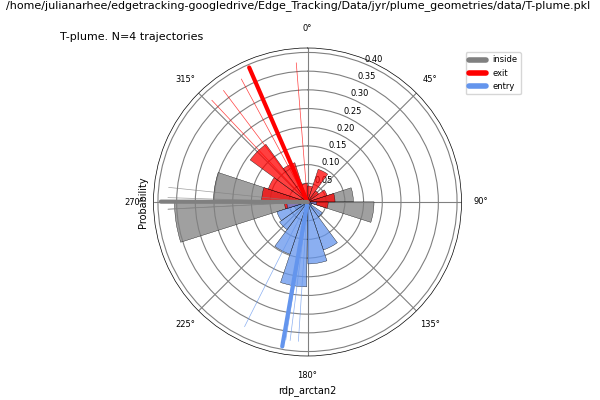

/home/julianarhee/edgetracking-googledrive/Edge_Tracking/Data/jyr/plume_geometries/figures/T-plume/rdp_arctan2_avg-fly_polar_T-plume_yt.svg


In [130]:
hist_var = 'rdp_arctan2'
weights_var='euclid_dist'
plot_polar = True

plot_type = 'polar' if plot_polar else 'lin'
fly_lw = 0.5
avg_lw = 3
avg_marker = 'v'
fly_marker = '|'
alpha=0.75

fig, ax  = pl.subplots(subplot_kw=dict(polar=plot_polar))
# histogram of ALL bouts across all flies
sns.histplot(data=entries_exits, x=hist_var, hue='rdp_boutdir', ax=ax, palette=rdp_boutdir_palette, 
             edgecolor='k', lw=0.25, alpha=alpha, stat='probability', common_norm=False, bins=20)
# plot each fly's average
ylim = ax.get_ylim()[-1]
b_list = []
for fn, ees in entries_exits.groupby('filename'):
    # get first/last
    ees = entries_exits[entries_exits['filename']==fn].copy() #d_[d_['rdp_ft_posx']].groupby('boutnum').agg(['first', 'last']).stack().reset_index().rename(columns={'level_1': 'order'})
    # get average
    avg_ = ees.groupby('rdp_boutdir').apply(util.get_weighted_average, hist_var='rdp_arctan2', weights_var=weights_var)
    for rdp_bdir in ees['rdp_boutdir'].unique():
        avg_dir = avg_[rdp_bdir]
        # plot animal's average
        if plot_polar:
            ax.plot([0, avg_dir], [0, ylim], alpha=alpha, color=rdp_boutdir_palette[rdp_bdir], lw=fly_lw, label=rdp_bdir) # theta is x
        else:
            ax.plot([avg_dir], [ylim], marker=fly_marker, alpha=alpha, color=rdp_boutdir_palette[rdp_bdir], label=rdp_bdir) # theta is x
# plot average across flies
ylim = ax.get_ylim()[-1]
for rdp_bdir, b_ in entries_exits.groupby('rdp_boutdir'):
    fly_avg = util.get_weighted_average(b_, hist_var=hist_var, weights_var=weights_var)
    util.circular_mean(b_.groupby('filename', as_index=False).apply(util.get_weighted_average, 
                            hist_var=hist_var, weights_var=weights_var).rename(columns={None: hist_var})[hist_var])
    if plot_polar:
        ax.plot([0, fly_avg], [0, ylim], color=rdp_boutdir_palette[rdp_bdir], lw=avg_lw, label=rdp_bdir) # theta is x
    else:
        ax.plot([fly_avg], [ylim], marker=avg_marker, color=rdp_boutdir_palette[rdp_bdir], label=rdp_bdir) # theta is x
if plot_polar:
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
else:
    ax.set_box_aspect(1)
    ax.tick_params(which='both', axis='both', length=2, width=0.5, color='k',
               direction='out', left=True, bottom=True)
    # ticks
    sns.despine(offset=4)
# legend
labels= ['inside', 'exit', 'entry']
colors = [rdp_boutdir_palette[l] for l in labels]
legh = putil.custom_legend(labels=labels, colors=colors)
ax.legend(handles=legh, bbox_to_anchor=(1,1), loc='upper left')
# label
n_filenames = entries_exits['filename'].nunique()
fig.text(0.1, 0.9, '{}. N={} trajectories'.format(experiment, n_filenames), fontsize=8)
util.label_figure(fig, figid)
# save
figname = '{}_avg-fly_{}'.format(hist_var, plot_type)
pl.savefig(os.path.join(figdir, '{}_{}{}.svg'.format(figname, experiment, plot_st)))
pl.savefig(os.path.join(figdir, '{}_{}{}.png'.format(figname, experiment, plot_st)))
print(os.path.join(figdir, '{}_{}{}.svg'.format(figname, experiment, plot_st)))

# save

In [126]:
etdir = os.path.join(srcdir, 'ets')
if not os.path.exists(etdir):
    os.makedirs(etdir)
    
# et_fpath = os.path.join(etdir, 'et_{}.pkl'.format(experiment))
with open(et_fpath, 'wb') as f:
    pkl.dump({'etdf_zero': etdf_zero,
              'etdf_filt': etdf_filt,
              'entries_exits': entries_exits}, f)
print(et_fpath)

/home/julianarhee/edgetracking-googledrive/Edge_Tracking/Data/jyr/plume_geometries/data/ets/et_T-plume.pkl
